# Predicting prevalence of hypertension on Zila level

## Notes

- Definition of diabetes:
    - Recommendation for diagnosis of hypertension [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4707193/)
- Hypertension if meets any of the following three criteria:
    - SBP ≥ 140 mmHg or DBP ≥ 90 mmHg
    - Told by a doctor to have high blood pressure (sh249)
    - Taking prescribed medicine to lower blood pressure (sh250)
    
- DHS Data
    - Three measurements of both systolic and diastolic blood pressure were taken during the survey at approximately 10-minute intervals between measurements.
    - The average of the second and third measurements was used to report respondent’s blood pressure values.
    - Arterial blood pressure is the force exerted by the blood on the wall of a blood vessel as the heart pumps (contracts) and relaxes. Systolic blood pressure (SBP) is the measures the force when the heart pumps (contracts), and the diastolic blood pressure (DBP) measures the degree of force when the heart is relaxes. The 2011 BDHS uses the American Heart Association guidelines for cut-off points for blood pressure measurements (AHA, 2003). The chart below summarizes the systolic and diastolic blood pressure values as they relate to hypertension classification. The cut-off points correspond to the clinical classification for hypertension as they relate to the systolic and diastolic blood pressure measurements.
   

## Packages

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import re
import glob
import logging
import itertools
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import pandas_ml as pd_ml
import matplotlib.pyplot as plt

%matplotlib inline
# import matplotlib.pylab as plt
# from matplotlib.pylab import rcParams

import rpy2.robjects as robjects
from rpy2.robjects import packages
from rpy2.robjects import pandas2ri

from scipy import io
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from datetime import timedelta
from datetime import datetime as dt

from dbfread import DBF

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## Custom functions

In [2]:
def subset_by_var1(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var].notna(),:]
    print(df.shape)
    return df


def subset_by_var2(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var] != -9,:]
    print(df.shape)
    return df


def remove_metadata(input_df, metadata):
    df = input_df.copy(deep=True)
    var_select = [var1 for var1,var2 in zip(metadata['variable'],metadata['model_keep']) if var2 == 0]
    print(df.shape)
    df = df.drop(var_select, axis=1)
    print(df.shape)
    return df 
 
def remove_uniform(input_df):
    df = input_df.copy(deep=True)
    var_list = []
    for key, var in enumerate(df):
        tmp = df[var].dropna()
        if len(tmp.unique()) == 1:
            var_list.append(var)
    print(df.shape)
    print(var_list)
    df = df.drop(var_list, axis=1)
    print(df.shape)
    return df
    
def remove_identical(input_df):
    df = input_df.copy(deep=True)
    var_pairs_check = []
    var_pairs = []
    for pair in itertools.combinations(list(df.columns),2):
        var_pairs.append(pair)
        var_pairs_check.append(all(df[pair[0]] == df[pair[1]]))
    selected_pairs = [pair for pair, check in zip(var_pairs, var_pairs_check) if check]
    selected_var = [var2 for var1,var2 in selected_pairs]
    print(df.shape)
    df = df.drop(list(set(selected_var)), axis=1)
    print(df.shape)
    return df


def remove_missing(input_df, threshold):
    df = input_df.copy(deep=True)
    drop_vars = []
    for key, var in enumerate(df):
        null_percent = round(df[var].isnull().mean() * 100,2)
        if null_percent >= threshold:
            drop_vars.append(var)
    print(df.shape)
    df = df.drop(drop_vars, axis=1)
    print(df.shape)
    return df


def check_variables(input_df):
    df = input_df.copy(deep=True)
    var_types = [var_n for var_t,var_n  in zip(df.dtypes, df.columns) if var_t == 'O']
    return var_types

def summarize_variables(input_df, metadata_df):
    metadata = metadata_df.copy(deep=True)
    metadata['num_values'] = 'NaN'
    for key, var in enumerate(metadata.values):
        metadata.loc[key,'num_values'] = len(input_df[var[0]].unique())
    return metadata


def determine_hypertension(input_df, option):
    df = input_df.copy(deep=True)
    df['hypertension'] = -9
    for key, value in enumerate(df.values):
        if option == 'valid':
            if (df.loc[key,'sh250'] == 1. or df.loc[key,'sh249'] == 1. or df.loc[key,'fsysto'] >= 140. or df.loc[key,'fdysto'] >= 90.):
                df.at[key, 'hypertension'] = 1
            elif (df.loc[key,'sh250'] == 0 or df.loc[key,'sh249'] == 0 or df.loc[key,'fsysto'] < 140 or df.loc[key,'fdysto'] < 90):
                df.at[key, 'hypertension'] = 0
            else:
                df.at[key,'hypertension'] = -9
        elif option == 'average':
            syst = np.mean([df.loc[key,'sh255s'],df.loc[key,'sh264s']])
            dyst = np.mean([df.loc[key,'sh255d'],df.loc[key,'sh264d']])
            if (df.loc[key,'sh250'] == 1. or df.loc[key,'sh249'] == 1. or syst >= 140. or dyst > 90.):
                df.at[key, 'hypertension'] = 1
            elif (df.loc[key,'sh250'] == 0 or df.loc[key,'sh249'] == 0 or syst < 140. or dyst < 90.):
                df.at[key, 'hypertension'] = 0
            else:
                df.at[key,'hypertension'] = -9
    return df  

def determine_hyperglycaemia(input_df):
    df = input_df.copy(deep=True)
    df['sh280'] = np.where(df['sh280'].isna(), 9999, df['sh280'])
    df['sh280'] = df['sh280'].astype(int).astype(str)
    df['meal'] = 1
    for key,time in enumerate(df['sh280']):
        try:
            df.at[key,'meal'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'meal'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh281'] = np.where(df['sh281'].isna(), 9999, df['sh281'])
    df['sh281'] = df['sh281'].astype(int).astype(str)
    df['drink'] = 1
    for key,time in enumerate(df['sh281']):
        try:
            df.at[key,'drink'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'drink'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh283t'] = np.where(df['sh283t'].isna(), 9999, df['sh283t'])
    df['sh283t'] = df['sh283t'].astype(int).astype(str)
    df['measure_time'] = 1
    for key,time in enumerate(df['sh283t']):
        try:
            df.at[key,'measure_time'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'measure_time'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    df['meal'] = pd.to_datetime(df['meal'], format='%Y-%m-%d %H:%M:%S')
    df['drink'] = pd.to_datetime(df['drink'], format='%Y-%m-%d %H:%M:%S')
    df['measure_time'] = pd.to_datetime(df['measure_time'], format='%Y-%m-%d %H:%M:%S')
    df['meal_delta'] = df['meal'] - df['measure_time']
    df['meal_delta'] = df['meal_delta']/np.timedelta64(1,'h')
    df['meal_fasting'] = np.where(df['meal_delta'] > 4, 1, 0)
    df['drink_delta'] = df['drink'] - df['measure_time']
    df['drink_delta'] = df['drink_delta']/np.timedelta64(1,'h')
    df['drink_fasting'] = np.where(df['drink_delta'] > 4, 1, 0)
    df['hyperglycaemia'] = -9
    # sh258: Ever told by a doctor/nurse to have diabetes
    # sh259: Taking medication for the diabetes
    # df.loc[key,'drink_fasting'] == 1. and df.loc[key,'meal_fasting'] == 1. and 
    # df.loc[key,'drink_fasting'] == 0. and df.loc[key,'meal_fasting'] == 0. and 
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh284b'] >= 126 or df.loc[key,'sh258'] == 1 or df.loc[key,'sh259'] == 1):
            df.at[key, 'hyperglycaemia'] = 1
        elif (df.loc[key,'sh284b'] < 126 or df.loc[key,'sh258'] == 0 or df.loc[key,'sh259'] == 0):
            df.at[key, 'hyperglycaemia'] = 0
        else:
            df.at[key, 'hyperglycaemia'] = -9
    return df 


def to_categorical(input_df, input_meta):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if str(input_meta[input_meta['variable'] == var].values[0][4]) == 'categorical':
            df[var] =  df[var].astype('str').astype('category')
    return df

def threshold_cut(input_df, threshold):
    df = input_df.copy(deep=True)
    df = df.sort_values(by='importance', ascending=False)
    df['cumsum'] = np.cumsum(df['importance'])
    df = df[df['cumsum'] >= threshold]
    return df

def read_svrs(path, pattern):
    data = {}
    for path, subdir, files in os.walk(path):
        for file in files:
            if file.endswith(pattern):
                itr = pd.read_stata(os.path.join(path,file), iterator=True)
                variables = list(itr.variable_labels().values())
                data[file] = pd.read_stata(os.path.join(path,file))
                data[file].columns = variables
    return data

def read_dbf(file):
    tmp = DBF(file)
    tmp = pd.DataFrame(iter(tmp))
    return tmp

def read_sav(file):
    foreign = packages.importr('foreign')
    pandas2ri.activate()
    df = foreign.read_spss(file, reencode=False)
    return pd.DataFrame(dict(zip(df.names, map(list,list(df)))))

def read_svrs(file):
    itr = pd.read_stata(file, iterator=True)
    variables = list(itr.variable_labels().values())
    data = pd.read_stata(os.path.join(file))
    original_variables = list(data.columns)
    data.columns = variables
    return data, original_variables

def eer_threshold(model, test_X, test_y):
    predictions = model.predict_proba(test_X)
    predictions = predictions[:,1]
    output = {}
    for i in range(5,100,1):
        y_predicted = np.where(predictions > i/100, 1, 0)
        cm = confusion_matrix(y_pred=y_predicted, y_true=test_y,)
        tn, fp, fn, tp = cm.ravel()
        n = test_y.value_counts()[0]
        p = test_y.value_counts()[1]
        precision = tp / (tp + fp) # positive predictive value
        recall = tp / (tp + fn) # true positive rate
        output[str(i/100)] = precision-recall
    output = pd.DataFrame.from_dict(output,orient='index', columns=['EER'])
    output['EER'] = np.absolute(output['EER'])
    output = output.sort_values(by='EER', ascending=True)
    display(output.head(10))
    return float(output.index[0]), output.iloc[0,0],

def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Hypertension'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(f"Accuracy : %.4g {accuracy_score(dtrain['Hypertension'].values, dtrain_predictions)}")
    print(f"AUC Score (Train): {roc_auc_score(dtrain['Hypertension'], dtrain_predprob)}]")
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = X_data_test.merge(dtest[['predprob']])
    print(f"AUC Score (Test): {roc_auc_score(results['Hypertension'], results['predprob'])}")
    print(alg.booster)
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Variables

In [3]:
NCD_DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/data_dd_dhs_ncd.csv'
c = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd.csv'
METADATA_M = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd_m.csv'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/'

SVRS2017_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/metadata_bbs_SRVS_17.csv'
SVRS2013_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/metadata_bbs_SRVS_13.csv'
SVRS2014_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/metadata_bbs_SRVS_14.csv.csv'

SVRS2012 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_12/tafsil-2p.dbf'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/pop_hh_14-05-2015.sav'
SVRS2014 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/tafsil2P_12-06-2015.sav'
SVRS2015 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_15/tafsil-2p.dbf'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/tafsl-2p.dta'

### Reading data

In [4]:
ncd_data = pd.read_csv(NCD_DATA)
ncd_metadata = pd.read_csv(METADATA_M)

### Creating hypertension target variable

In [5]:
# ncd_data = determine_hypertension(input_df=ncd_data, option='valid')
# print(ncd_data['hypertension'].value_counts())

In [6]:
ncd_data = determine_hypertension(input_df=ncd_data, option='average')
print(ncd_data['hypertension'].value_counts())

-9    75739
 0     5644
 1     2348
Name: hypertension, dtype: int64


In [7]:
ncd_metadata = summarize_variables(input_df=ncd_data, metadata_df=ncd_metadata)
ncd_metadata.head()
ncd_metadata.to_csv(METADATA_M, index=False, index_label=False)

In [8]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shbm,shri,shcmc,shflg,shsmk,shresi,shed1,shed2,shed3,hypertension
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9


In [9]:
ncd_metadata.head()

,variable,description,model_keep,num_values,type
0,hhid,Case Identification,0,17141,numeric
1,hvidx,Line number,0,31,categorical
2,hv000,Country code and phase,0,1,categorical
3,hv001,Cluster number,0,600,categorical
4,hv002,Household number,0,184,categorical


In [10]:
for num, var in enumerate(ncd_metadata['description']):
    if "blood pressure" in var:
        print(ncd_metadata['variable'][num], ncd_metadata['description'][num])

sh19 Eligible for blood glucose and blood pressure tests: Woman
sh20 Eligible for height, weight,blood glucose and blood pressure tests: Woman
sh22 Eligible for height,weight,blood glucose and blood pressure tests:Man
sh241 Consent for blood pressure measurement
sh244 Arm Circumference measurement for blood pressure
sh245 Time for first blood pressure test
sh246s Systolic blood pressure measurement
sh246d Diastolic blood pressure measurement
sh249 Told by a doctor to have high blood pressure
sh250 Taking prescribed medicine to lower blood pressure
sh253 Time for second blood pressure test
sh254 Consent for second blood pressure test
sh255s Systolic blood pressure
sh255d Diastolic blood pressure
sh262 Time for third blood pressure test
sh263 Consent for third blood pressure test
sh264s Systolic blood pressure
sh264d Diastolic blood pressure
fdysto Valid Dystolic blood pressure


In [11]:
for num, var in enumerate(ncd_metadata['description']):
    if "tolic blood pressure" in var:
        print(ncd_metadata['variable'][num], ncd_metadata['description'][num])

sh246s Systolic blood pressure measurement
sh246d Diastolic blood pressure measurement
sh255s Systolic blood pressure
sh255d Diastolic blood pressure
sh264s Systolic blood pressure
sh264d Diastolic blood pressure
fdysto Valid Dystolic blood pressure


### Subset data by target variable missingness

In [12]:
data = subset_by_var2(input_df=ncd_data, var='hypertension')
'hypertension' in data.columns

(83731, 384)
(7992, 384)


True

### Subset data by metadata file (variables to keep column)

In [13]:
data = remove_metadata(input_df=data, metadata=ncd_metadata)
'hypertension' in data.columns

(7992, 384)
(7992, 307)


True

### Remove uniformed variables (no variation)

In [14]:
data = remove_uniform(input_df=data)
'hypertension' in data.columns

(7992, 307)
['hv015', 'hv020', 'hv027', 'hv042', 'hv120', 'hv121', 'hv122', 'hv124', 'sh21', 'ha62', 'hb62']
(7992, 296)


True

### Removing missing by threshold 

In [15]:
data = remove_missing(input_df=data, threshold=1)
'hypertension' in data.columns

(7992, 296)
(7992, 102)


True

### Checking variables

In [16]:
check_variables(input_df=data)

[]

### Removing meta variables

In [17]:
data = data.drop(['Unnamed: 0'],axis=1)
data.head()

,hv009,hv010,hv011,hv012,hv013,hv014,hv016,hv017,hv024,hv025,...,sh234c,sh237,sh239,sh241,sh257,shwh,shcmc,shed1,shed3,hypertension
16,6,0,0,6,2,1,10,1,1,2,...,58.0,0.0,0.0,1.0,1.0,0.0,642.0,0.0,0.0,0
17,6,0,0,6,2,1,10,1,1,2,...,60.0,1.0,13.0,1.0,1.0,3.0,614.0,1.0,1.0,1
26,5,1,1,5,5,1,10,1,1,2,...,36.0,1.0,52.0,1.0,1.0,0.0,907.0,1.0,1.0,0
39,2,0,0,2,2,0,10,1,1,2,...,65.0,0.0,13.0,1.0,1.0,3.0,556.0,0.0,0.0,1
40,2,0,0,2,2,0,10,1,1,2,...,55.0,0.0,0.0,1.0,1.0,0.0,669.0,0.0,0.0,0


# Predictors
- **Education (completed in years)**
    1. DHS: **hv108** - Education completed in single years
    2. SVRS2017: **q_16** - Level of Education
- **Age**
    1. DHS: **hv105** - Age of household members
    2. SVRS2017: **q_10** - Age
- **Urban/rural**
    1. DHS: 'hv025'
    2. SVRS2017: 'Rural/Urban' / 'rmo'
- **Sex**
    1. DHS:'hv104'
    2. SVRS2017: 'Sex'

In [18]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
orig_data = data[['hv108', 'hv105', 'hv025', 'hv104', 'hypertension']]
orig_data.columns = variables + ['Hypertension']
orig_data = orig_data[orig_data['Education'] != 98]
orig_data = orig_data[orig_data['Education'] != 97]
orig_data = orig_data[orig_data['Hypertension'] != 9]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data.head()

,Education,Age,Urban/Rural,Gender,Hypertension
16,0,58,2,2,0
17,3,60,2,1,1
26,2,36,2,1,0
39,0,65,2,1,1
40,0,55,2,2,0


### DHS Codes	New Codes Categorisation 1
- 0		No education [0]
- 1		Primary Education [1]
- 2		Primary Education [1]
- 3		Primary Education [1]
- 4		Primary Education [1]
- 5		Primary Education [1]
- 6		Secondary Education [2]
- 7		Secondary Education [2]
- 8		Secondary Education [2]
- 9		Secondary Education [2]
- 10	Secondary Education [2]
- 11	Higher Secondary Education [3]
- 12	Higher Secondary Education [3]
- 13	Undergraduate and more [4]
- 14	Undergraduate and more [4]
- 15	Undergraduate and more [4]
- 16	Undergraduate and more [4]
- 17	Undergraduate and more [4]
- 18	Undergraduate and more [4]
- 97	Remove [-1]
- 98	Remove [-1]

### DHS Codes	New Codes Categorisation 2
- **0** [No education]: 0
- **1,2,3,4** [Primary incomplete]: 1
- **5** [Completed primary]: 2
- **6,7,8,9** [Secondary incomplete]: 3
- **10** [Completed secondary]: 4
- **11-18** [More than secondary]: 5
- **97** [Missing]: Remove
- **98** [Missing]: Remove

In [19]:
edu_categorisation_1 = []
for i in orig_data['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i >= 11 and i <= 12):
        edu_categorisation_1.append(3)
    elif (i >= 13 and i <= 18):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))
print(orig_data['Education'].value_counts().sort_index())

Counter({0: 3733, 1: 2128, 2: 1491, 4: 366, 3: 274})
0     3733
1      236
2      355
3      295
4      413
5      829
6      149
7      214
8      306
9      420
10     402
11       7
12     267
13       2
14     170
15      50
16     110
17      31
18       3
Name: Education, dtype: int64


In [20]:
edu_categorisation_2 = []
for i in orig_data['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 18):
        edu_categorisation_2.append(5)
    elif (i == 97 or i == 98):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_2))
print(orig_data['Education'].value_counts().sort_index())

Counter({0: 3733, 1: 1299, 3: 1089, 2: 829, 5: 640, 4: 402})
0     3733
1      236
2      355
3      295
4      413
5      829
6      149
7      214
8      306
9      420
10     402
11       7
12     267
13       2
14     170
15      50
16     110
17      31
18       3
Name: Education, dtype: int64


In [21]:
orig_data['Urban/Rural'] = orig_data['Urban/Rural'].astype('category')
orig_data['Gender'] = orig_data['Gender'].astype('category')
orig_data['Education_1'] = edu_categorisation_1
orig_data['Education_1'] = orig_data['Education_1'].astype('category')
orig_data['Education_2'] = edu_categorisation_2
orig_data['Education_2'] = orig_data['Education_2'].astype('category')

y = orig_data['Hypertension']
# X = orig_data.drop(['Hypertension', 'Education', 'Education_1'], axis=1)
X = orig_data.drop(['Hypertension', 'Education', 'Education_2'], axis=1)
X.dtypes
X = pd.get_dummies(X)
X.dtypes

Age              int64
Urban/Rural_1    uint8
Urban/Rural_2    uint8
Gender_1         uint8
Gender_2         uint8
Education_1_0    uint8
Education_1_1    uint8
Education_1_2    uint8
Education_1_3    uint8
Education_1_4    uint8
dtype: object

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2, random_state=84)

# Fine-tuning the model - Hypertension

In [23]:
X_data_train = X_train.copy(deep=True)
X_data_train['Hypertension'] = y_train
X_data_test = X_test.copy(deep=True)
X_data_test['Hypertension'] = y_test


Model Report
Accuracy : %.4g 0.7301736274049742
AUC Score (Train): 0.7071766002574685]
AUC Score (Test): 0.6863091149419736
gbtree


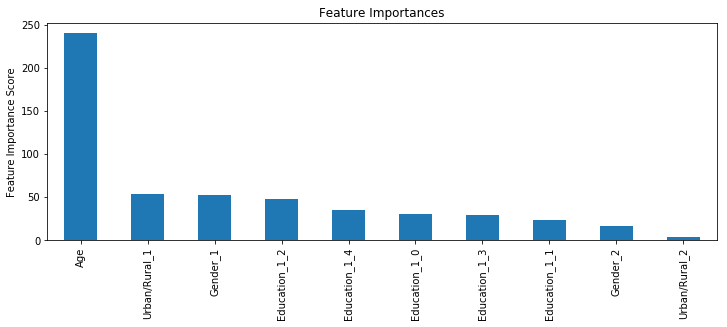

In [24]:
plt.rcParams['figure.figsize'] = 12, 4
target = 'Hypertension'
predictors = [x for x in X_data_train.columns if x not in [target]]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb1, X_data_train, X_data_test, predictors)

## Grid seach on n_estimators: Initial step

In [25]:
param_test0 = {
    'n_estimators':range(10,1000,100)
}
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch0.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(10, 1000, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [26]:
#gsearch0.cv_results_,gsearch0.best_params_, gsearch0.best_score_
print("#"*100)
print(gsearch0.best_params_)
print(gsearch0.best_score_)
print("#"*100)

####################################################################################################
{'n_estimators': 10}
0.6761498925087835
####################################################################################################


In [27]:
param_test0a = {
    'n_estimators':range(2,10,1)
}
gsearch0a = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test0a, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch0a.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(2, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [28]:
#gsearch0a.cv_results_,gsearch0a.best_params_, gsearch0a.best_score_
print("#"*100)
print(gsearch0a.best_params_)
print(gsearch0a.best_score_)
print("#"*100)

####################################################################################################
{'n_estimators': 6}
0.6761329748007746
####################################################################################################


## Grid seach on max_depth and min_child_weight: Initial step

In [ ]:
param_test1 = {
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,10,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=6, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch1.fit(X_train,y_train)

In [ ]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)
print("#"*100)
#gsearch1.cv_results_,gsearch1.best_params_, gsearch1.best_score_

## Grid seach on max_depth and min_child_weight: Step 2

In [29]:
param_test2 = {
    'max_depth':[4,5,6,7,8],
    'min_child_weight':[6,7,8,9,10]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=6, max_depth=6,
                                        min_child_weight=8, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=8, missing=None,
       n_estimators=6, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6, 7, 8], 'min_child_weight': [6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [30]:
#gsearch2.cv_results_,gsearch2.best_params_, gsearch2.best_score_
print("#"*100)
print(gsearch2.best_params_)
print(gsearch2.best_score_)
print("#"*100)

####################################################################################################
{'max_depth': 6, 'min_child_weight': 8}
0.6780296014211725
####################################################################################################


## Grid seach on gamma: Initial step

In [31]:

#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[0,1,5] + [i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=6, max_depth=6,
                                        min_child_weight=8, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=8, missing=None, n_estimators=6,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0, 1, 5, 0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [32]:
# gsearch3.cv_results_,gsearch3.best_params_, gsearch3.best_score_
print("#"*100)
print(gsearch3.best_params_)
print(gsearch3.best_score_)
print("#"*100)

####################################################################################################
{'gamma': 0}
0.6780296014211725
####################################################################################################


In [33]:
#Choose all predictors except target & IDcols
param_test4= {
    'gamma':[0, 0.025, 0.05, 0.075, 0.1]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=6, max_depth=6,
                                        min_child_weight=8, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=8, missing=None, n_estimators=6,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0, 0.025, 0.05, 0.075, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [34]:
# gsearch3.cv_results_,gsearch3.best_params_, gsearch3.best_score_
print("#"*100)
print(gsearch4.best_params_)
print(gsearch4.best_score_)
print("#"*100)

####################################################################################################
{'gamma': 0.05}
0.6782331833209152
####################################################################################################



Model Report
Accuracy : %.4g 0.7250117315814172
AUC Score (Train): 0.7012008824120523]
AUC Score (Test): 0.6988656912056262
gbtree


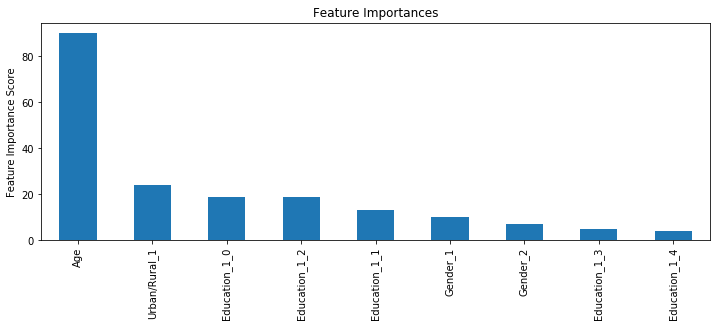

In [36]:
predictors = [x for x in X_data_train.columns if x not in [target]]
xgb2 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=6,
        max_depth=6,
        min_child_weight=8,
        gamma=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb2, X_data_train, X_data_test, predictors)

## Grid seach on subsample and colsample_bytree: Initial step

In [44]:
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(60,100,5)],
    'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=6, max_depth=6,
                                        min_child_weight=8, gamma=0.05, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.05, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=8, missing=None,
       n_estimators=6, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [45]:
#gsearch5.cv_results_,gsearch5.best_params_, gsearch5.best_score_
print("#"*100)
print(gsearch5.best_params_)
print(gsearch5.best_score_)
print("#"*100)

####################################################################################################
{'colsample_bytree': 0.6, 'subsample': 0.85}
0.6789138069872
####################################################################################################


## Grid seach on subsample and colsample_bytree: Fine-tune

In [49]:
#Choose all predictors except target & IDcols
param_test6 = {
    'subsample':[i/100.0 for i in range(75,95)],
    'colsample_bytree':[i/100.0 for i in range(50,70)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=6, max_depth=6,
                                        min_child_weight=8, gamma=0.05, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch6.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.05, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=8, missing=None,
       n_estimators=6, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94], 'colsample_bytree': [0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [50]:
print(gsearch6.best_params_)
print(gsearch6.best_score_)
print("#"*100)
#gsearch6.cv_results_,gsearch6.best_params_, gsearch6.best_score_

{'colsample_bytree': 0.6, 'subsample': 0.85}
0.6789138069872
####################################################################################################


## Grid seach on reg_alpha: Initial step

In [51]:
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=6, max_depth=6,
                                        min_child_weight=8, gamma=0.05, subsample=0.85, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch7.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.05, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=8, missing=None,
       n_estimators=6, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.85),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [52]:
#gsearch7.cv_results_,gsearch7.best_params_, gsearch7.best_score_
print("#"*100)
print(gsearch7.best_params_)
print(gsearch7.best_score_)
print("#"*100)

####################################################################################################
{'reg_alpha': 1e-05}
0.6789138069872
####################################################################################################


## Grid seach on reg_alpha: Fine-tune

In [55]:
# Choose all predictors except target & IDcols
param_test8 = {
    'reg_alpha':[1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-4, 1e-4]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=6, max_depth=6,
                                        min_child_weight=8, gamma=0.05, subsample=0.85, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch8.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.05, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=8, missing=None,
       n_estimators=6, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.85),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-07, 5e-07, 1e-06, 5e-06, 1e-05, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [56]:
# gsearch8.cv_results_,gsearch8.best_params_, gsearch8.best_score_
print("#"*100)
print(gsearch8.best_params_)
print(gsearch8.best_score_)
print("#"*100)


####################################################################################################
{'reg_alpha': 1e-07}
0.6789138069872
####################################################################################################



Model Report
Accuracy : %.4g 0.7246988894102925
AUC Score (Train): 0.7041131090524225]
AUC Score (Test): 0.6864342773070227
gbtree


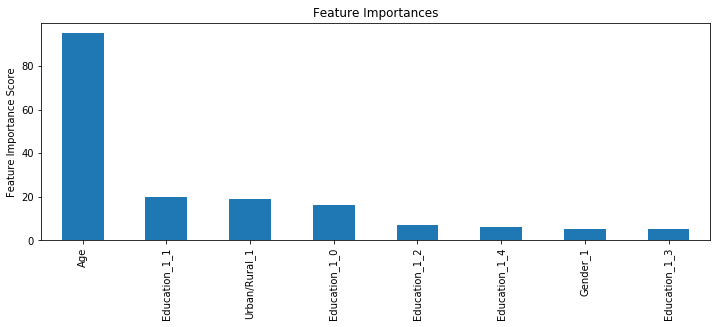

In [59]:
xgb3 = XGBClassifier(
        learning_rate =0.2,
        n_estimators=6,
        max_depth=6,
        min_child_weight=8,
        gamma=0.05,
        subsample=0.85,
        colsample_bytree=0.6,
        reg_alpha=1e-07,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb3, X_data_train, X_data_test, predictors)

# Evaluate importance and accuracy

In [63]:
eer_threshold(xgb3, test_X=X_test, test_y=y_test)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: RuntimeWarning: invalid value encountered in long_scalars


,EER
0.4,0.000959
0.39,0.072441
0.41,0.075717
0.38,0.099076
0.37,0.143610
0.42,0.154755
0.57,0.164557
0.36,0.180921
0.58,0.197890
0.43,0.207565


(0.4, 0.00095895665515916)

0.02873752783046095


0.06086163665374972

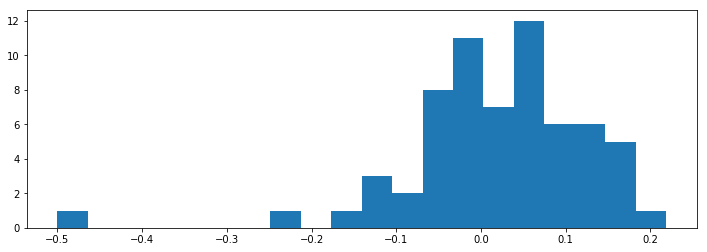

In [64]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.4, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'shdistrict']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].median()

-0.005076142131979711


0.026972988764516342

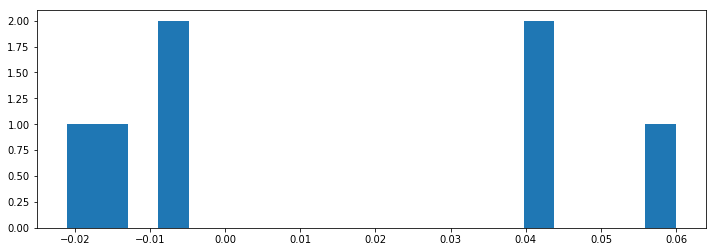

In [65]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.4, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'hv024']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].mean()

In [66]:
y_predicted = xgb3.predict_proba(X_test)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.4, 1, 0)
cm1= pd_ml.ConfusionMatrix(y_pred=y_predicted, y_true=y_test,)
cm2 = confusion_matrix(y_pred=y_predicted, y_true=y_test,)
print(cm1)

Predicted  False  True  __all__
Actual                         
False         18     4       22
True           6     3        9
__all__       24     7       31


In [67]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1125
           1       0.45      0.45      0.45       474

   micro avg       0.68      0.68      0.68      1599
   macro avg       0.61      0.61      0.61      1599
weighted avg       0.68      0.68      0.68      1599



# Predicting hypertension prevalence using SVRS 2013, 2014 and 2017 data

- SVRS 2012: DBF
- SVRS 2013: SAV
- SVRS 2014: SAV
- SVRS 2015: DBF
- SVRS 2017: DTA

In [ ]:
for var in ncd_data.columns: 
    print(var,len(ncd_data[var].value_counts()))

In [ ]:
tr = eer_threshold(model=xgb3,test_X=X_test, test_y=y_test)
tr

In [ ]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.37, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'shdistrict']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].median()

In [ ]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.37, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'hv024']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].mean()

In [ ]:
y_predicted = xgb3.predict_proba(X_test)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.37, 1, 0)
cm1= pd_ml.ConfusionMatrix(y_pred=y_predicted, y_true=y_test,)
cm2 = confusion_matrix(y_pred=y_predicted, y_true=y_test,)
print(cm2)

In [ ]:
print(classification_report(y_test, y_predicted))